In [1]:
import numpy as np
import pandas as pd

np.random.seed(27)

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1
2.3.0


# Set up OpenAQ, Meteostat APIs
OpenAQ: https://openaq.org/ MeteoStat: https://meteostat.net/en

Tools py-openaq: https://github.com/dhhagan/py-openaq meteostat: https://dev.meteostat.net/python/

In [2]:
import openaq
# Import Meteostat library and dependencies
from meteostat import Point, Hourly, Daily

openaq = openaq.OpenAQ(version="v2")

class Location:
    def __init__(self, name, lat, lon):
        self.name = name
        self.lat = lat
        self.lon = lon


locations_PL = []

cities = openaq.cities(country="PL", limit=100000, df=True)["city"]

for city in cities:
    print(city)
    try:
        res = openaq.locations(city=city, df=True)[["coordinates.latitude","coordinates.longitude"]].mean()
    
        locations_PL.append(Location(city, res["coordinates.latitude"], res["coordinates.longitude"]))
    except:
        print("-----------Skipped {}-----------".format(city))

Augustów
Belsk
Belsk Duży
Biała
Biała Podlaska
Białystok
Bielsko-Biała
Biskupiec
Borówiec
Borsukowizna
Brzeg
Bydgoszcz
Chełm
Chełmno
Chojnice
Ciechocinek
Cieszyn
Czerniawa
Czerwionka-Leszczyny
Częstochowa
Dąbrowa Górnicza
Dębica
Diabla Góra
Duszniki-Zdrój
Działoszyn
Dzierżoniów
Elbląg
Ełk
Florianka
Gajew
Gdańsk
Gdynia
Gliwice
Głubczyce
Goczałkowice-Zdrój
Gołdap
Gołuchów
Gorzów Wielkopolski
Grajewo
Granica
Grudziądz
Gubin
Guty Duże
Horyniec-Zdrój
Inowrocław
Jarczew
Jarosław
Jasło
Jawor
Jędrzejów
Jelenia Góra
Kalisz
Kamienna Góra
Karpacz
Kaszów
Katowice
Kędzierzyn-Koźle
Kielce
Kłodzko
Kołobrzeg
Koniczynka
Konin
Końskie
Konstancin-Jeziorna
Kościerzyna
Kostrza
Koszalin
Koziegłowy
Kraków
Krasnobród
Krempna
Krosno
Krynica-Zdrój
Krzyżówka
Kutno
Lądek-Zdrój
Łask
Latoszyn
Łeba
Lębork
Legionowo
Legnica
Liniewko Kościerskie
Łódź
Łomża
Lubań
Lublin
Lubliniec
Malbork
Małogoszcz
Mielec
MIlicz
-----------Skipped MIlicz-----------
Mińsk Mazowiecki
Mogilno
Mosina
Mszana Dolna
Nakło nad Notecią
Nałęczów

In [3]:
from datetime import datetime, timedelta
import time

# Select Gdańsk because it is similar to Athens
selected_location = locations_PL[30]
print(selected_location.name)
# Format coordinates to align with OpenAQ standards
coordinates = "{},{}".format(round(selected_location.lat, 8), round(selected_location.lon, 8))

now = datetime(2021,10,1)

# For some reason the OpenAQ API accepts the date only in this way
date_from = datetime(2020 , 5, 10)
date_to = datetime(now.year, now.month, now.day) + timedelta(days=1)

print("Time Range: {} - {}".format(date_from, date_to))

selected_pollutants = ['pm25','pm10','no2','o3','so2','co']

# Create empty Dataframe
df_pollutants = pd.DataFrame(columns=selected_pollutants)

# getPollutants()

for pollutant in selected_pollutants:
    locations = openaq.locations(coordinates=coordinates, parameter=pollutant, radius=20000, df=True, has_geo=True)

    dfs_array = []
    for location in locations["id"]:
        try:
            time.sleep(3)
            df = openaq.measurements(location=location,
                                     date_from=date_from.date(), 
                                     date_to=date_to.date(),
                                     limit=100000, 
                                     parameter=pollutant,
                                     df=True,
                                     sort="asc")[["value"]].resample('H').mean()
            
            dfs_array.append(df)
            print("Added location {}".format(location))
        
        except:
            print("Skipped location {}".format(location))
    
    dfs_array = sorted(dfs_array,key=lambda x:x.index[0])
    df_pollutants[pollutant] = pd.concat(dfs_array, join="outer", axis = 1, sort=False).mean(axis=1)
    print("Added pollutant {}".format(pollutant))
    print("---------------------")

print("Data fetching completed!")

df_pollutants

Gdańsk
Time Range: 2020-05-10 00:00:00 - 2021-10-02 00:00:00
Added location 10757
Added location 225370
Added location 225374
Added location 10763
Added location 10756
Added pollutant pm25
---------------------
Added location 10757
Added location 225370
Added location 225374
Added location 7757
Skipped location 7059
Added location 10763
Added location 10770
Skipped location 7258
Added location 10756
Added pollutant pm10
---------------------
Added location 10757
Added location 225370
Added location 225374
Added location 7757
Skipped location 7059
Skipped location 7265
Added location 10763
Added location 10770
Skipped location 7258
Added location 10756
Added pollutant no2
---------------------
Added location 10757
Skipped location 7265
Added location 10756
Added pollutant o3
---------------------
Added location 10757
Added location 225370
Added location 225374
Added location 7757
Skipped location 7265
Added location 10763
Added location 10770
Skipped location 7258
Added location 10756
A

,pm25,pm10,no2,o3,so2,co
date.local,,,,,,
2020-05-10 02:00:00,30.17140,35.165320,23.364640,36.02235,3.420006,406.509750
2020-05-10 03:00:00,24.94110,26.857200,17.198144,41.85340,2.923762,380.546500
2020-05-10 04:00:00,20.40360,24.340960,14.874060,45.85035,3.265424,341.578500
2020-05-10 05:00:00,13.34030,12.202140,9.750350,59.84075,3.237568,280.203000
2020-05-10 06:00:00,13.86080,17.599560,14.425900,55.44545,3.236954,303.834500
...,...,...,...,...,...,...
2021-10-01 22:00:00,13.45540,18.340750,29.615100,38.53295,4.863708,334.145667
2021-10-01 23:00:00,15.29730,19.497175,20.857360,44.17460,4.779466,329.587333
2021-10-02 00:00:00,16.94295,20.955375,19.247740,39.24330,4.278694,334.217000


array([<AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>], dtype=object)

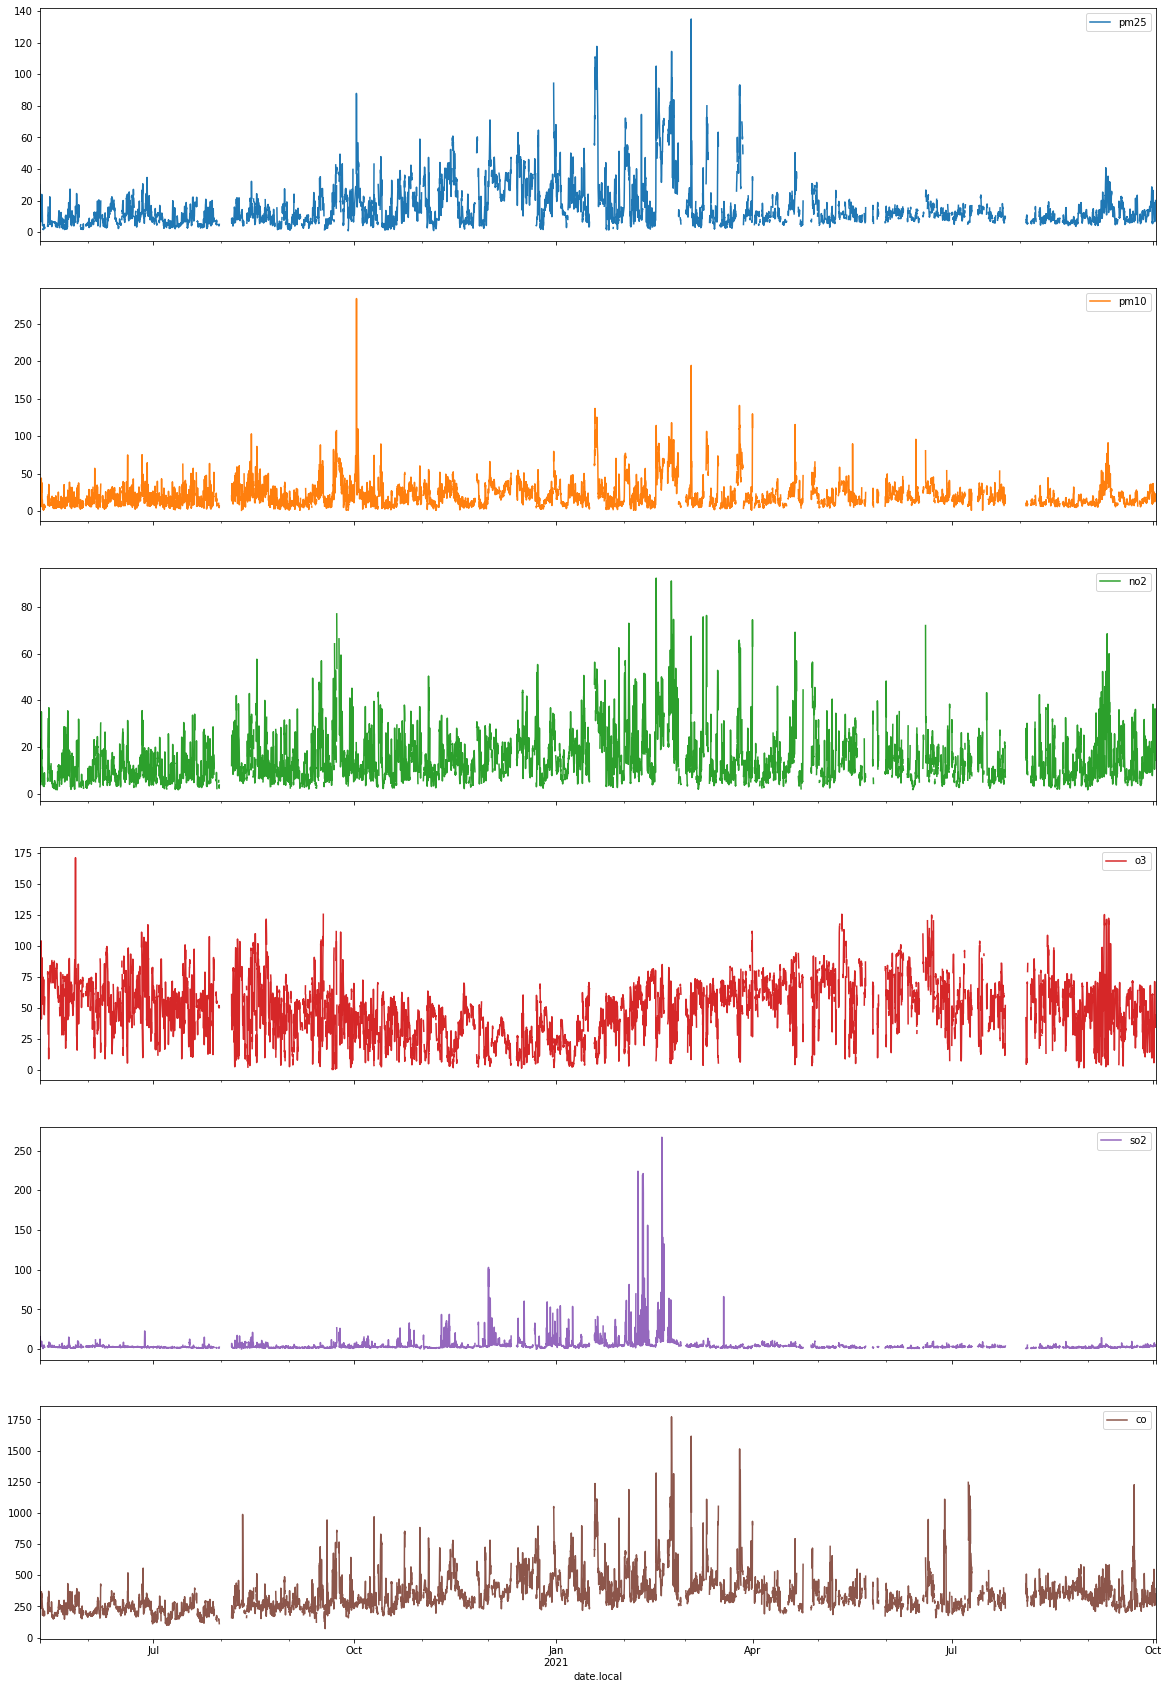

In [4]:
df_pollutants.plot(figsize=(20,30), subplots=True)

In [5]:
# Create Point for Gdańsk
# We will give the median between the maximum: 180m, minimum: 0m elevation of Gdańsk 

loc = Point(selected_location.lat, selected_location.lon, 90)

# temp  The air temperature in °C
# dwpt  The dew point in °C
# rhum  The relative humidity in percent (%)
# prcp  The one hour precipitation total in mm
# snow  The snow depth in mm
# wdir  The average wind direction in degrees (°)
# wspd  The average wind speed in km/h
# wpgt  The peak wind gust in km/h
# pres  The average sea-level air pressure in hPa
# tsun  The one hour sunshine total in minutes (m)
# coco  The weather condition code

# Get hourly data
df_weather = Hourly(loc=loc, start=date_from, end=date_to)
df_weather = df_weather.normalize()
df_weather = df_weather.fetch()

# Remove columns that hold no values
weather_features = ['dwpt', 'prcp', 'snow', 'wdir', 'wpgt', 'tsun']
df_weather.drop(weather_features, axis=1, inplace=True)
# df_weather = df_weather.interpolate(method='time')

final_df = df_pollutants.merge(df_weather, left_index=True, right_index=True)

final_df

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco
2020-05-10 02:00:00,30.171400,35.165320,23.364640,36.02235,3.420006,406.509750,4.3,99.9,0.1,1013.0,5.0
2020-05-10 03:00:00,24.941100,26.857200,17.198144,41.85340,2.923762,380.546500,4.3,99.9,1.8,1012.0,1.0
2020-05-10 04:00:00,20.403600,24.340960,14.874060,45.85035,3.265424,341.578500,5.3,93.0,1.8,1012.0,2.0
2020-05-10 05:00:00,13.340300,12.202140,9.750350,59.84075,3.237568,280.203000,11.2,58.4,0.1,1012.0,2.0
2020-05-10 06:00:00,13.860800,17.599560,14.425900,55.44545,3.236954,303.834500,13.3,51.2,12.9,1012.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,10.227040,17.265425,36.352360,41.57620,4.017824,349.459000,11.0,74.0,16.7,1023.2,2.0
2021-10-01 21:00:00,12.011955,17.995700,31.171180,43.12280,4.341456,341.442000,10.6,75.0,16.7,1023.0,2.0
2021-10-01 22:00:00,13.455400,18.340750,29.615100,38.53295,4.863708,334.145667,10.4,77.1,14.8,1022.6,2.0
2021-10-01 23:00:00,15.297300,19.497175,20.857360,44.17460,4.779466,329.587333,10.1,79.1,14.8,1022.1,2.0


## Fill any empty value

In [6]:
cols_with_Nan = final_df.columns[final_df.isnull().any()].tolist()

if cols_with_Nan:
    for col in cols_with_Nan:
        while(final_df[col].isnull().sum() > 0):
            final_df[col] = final_df[col].fillna(final_df[col].rolling('4D',min_periods=1).mean())
        final_df[col] = final_df[col].interpolate(method='pchip', limit_direction='both')
        
final_df.isnull().sum()

pm25    0
pm10    0
no2     0
o3      0
so2     0
co      0
temp    0
rhum    0
wspd    0
pres    0
coco    0
dtype: int64

# Calculate AQI for each pollutant

EEA AQI TABLE

| Key | Category | PM2,5 μg/m³ | PM10 μg/m³ | NO2 ppb | O3 ppb | SO2 ppb
| :- | :- | :- | :- | :- | :- | :- |
| 1 | Good | 0-10 | 0-20 | 0-40 | 0-50 | 0-100 | 
| 2 | Fair | 10-20 | 20-40 | 40-90 | 50-100 | 100-200 | 
| 3 | Moderate | 20-25 | 40-50 | 90-120 | 100-130 | 200-350 | 
| 4 | Poor | 25-50 | 50-100 | 120-230 | 130-240 | 350-500 |
| 5 | Very Poor | 50-75 | 100-150 | 230-340 | 240-380 | 500-750 |
| 6 | Extremely Poor | 75-800 | 150-1200 | 340-1000 | 380-800 | 750-1250 |

We will use key numbers for each category:

Good: 1
Fair: 2
Moderate: 3
Poor: 4
Very Poor: 5
Extremely Poor: 6

### Define functions to calculate AQI for each pollutant

In [7]:
def calcPM25(x):
    if x <= 10:
        return 1
    elif x >=11 and x <= 20:
        return 2
    elif x >=21 and x <= 25:
        return 3
    elif x >=26 and x <= 50:
        return 4
    elif x >=51 and x <= 75:
        return 5
    elif x >=76:
        return 6
    else:
        return 1
    
def calcPM10(x):
    if x <= 20:
        return 1
    elif x >=21 and x <= 40:
        return 2
    elif x >=41 and x <= 50:
        return 3
    elif x >=51 and x <= 100:
        return 4
    elif x >=101 and x <= 150:
        return 5
    elif x >=151:
        return 6
    else:
        return 1
    
def calcNO2(x):
    if x <= 40:
        return 1
    elif x >=41 and x <= 90:
        return 2
    elif x >=91 and x <= 120:
        return 3
    elif x >=121 and x <= 230:
        return 4
    elif x >=231 and x <= 340:
        return 5
    elif x >=341:
        return 6
    else:
        return 1
    
def calcO3(x):
    if x <= 50:
        return 1
    elif x >=51 and x <= 100:
        return 2
    elif x >=101 and x <= 130:
        return 3
    elif x >=131 and x <= 240:
        return 4
    elif x >=241 and x <= 380:
        return 5
    elif x >=381:
        return 6
    else:
        return 1
    
def calcSO2(x):
    if x <= 100:
        return 1
    elif x >=101 and x <= 200:
        return 2
    elif x >=201 and x <= 350:
        return 3
    elif x >=351 and x <= 500:
        return 4
    elif x >=501 and x <= 750:
        return 5
    elif x >=751:
        return 6
    else:
        return 1

    
final_df["pm25_AQI"] = final_df["pm25"].apply(lambda x: calcPM25(x))
final_df["pm10_AQI"] = final_df["pm10"].apply(lambda x: calcPM10(x))
final_df["no2_AQI"] = final_df["no2"].apply(lambda x: calcNO2(x))
final_df["o3_AQI"] = final_df["o3"].apply(lambda x: calcO3(x))
final_df["so2_AQI"] = final_df["so2"].apply(lambda x: calcSO2(x))

Source: https://www.euronews.com/weather/copernicus-air-quality-index

The overall hourly European Air Quality index is simply defined as the highest value of the 5 individual pollutants indexes computed for the same hour. For instance, if the indices relative to O3, NO2, SO2, PM2.5 and PM10 are 1,3,1,2,2 respectively, the overall index will be 3.

In [8]:
# final_df["overall_AQI"] = max(final_df[["pm25_AQI", "pm10_AQI", "o3_AQI", "so2_AQI", "co_AQI"]])
final_df["overall_AQI"] = final_df[["pm25_AQI","pm10_AQI","no2_AQI","o3_AQI","so2_AQI"]].max(axis=1)

final_df

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
2020-05-10 02:00:00,30.171400,35.165320,23.364640,36.02235,3.420006,406.509750,4.3,99.9,0.1,1013.0,5.0,4,2,1,1,1,4
2020-05-10 03:00:00,24.941100,26.857200,17.198144,41.85340,2.923762,380.546500,4.3,99.9,1.8,1012.0,1.0,3,2,1,1,1,3
2020-05-10 04:00:00,20.403600,24.340960,14.874060,45.85035,3.265424,341.578500,5.3,93.0,1.8,1012.0,2.0,1,2,1,1,1,2
2020-05-10 05:00:00,13.340300,12.202140,9.750350,59.84075,3.237568,280.203000,11.2,58.4,0.1,1012.0,2.0,2,1,1,2,1,2
2020-05-10 06:00:00,13.860800,17.599560,14.425900,55.44545,3.236954,303.834500,13.3,51.2,12.9,1012.0,2.0,2,1,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,10.227040,17.265425,36.352360,41.57620,4.017824,349.459000,11.0,74.0,16.7,1023.2,2.0,1,1,1,1,1,1
2021-10-01 21:00:00,12.011955,17.995700,31.171180,43.12280,4.341456,341.442000,10.6,75.0,16.7,1023.0,2.0,2,1,1,1,1,2
2021-10-01 22:00:00,13.455400,18.340750,29.615100,38.53295,4.863708,334.145667,10.4,77.1,14.8,1022.6,2.0,2,1,1,1,1,2
2021-10-01 23:00:00,15.297300,19.497175,20.857360,44.17460,4.779466,329.587333,10.1,79.1,14.8,1022.1,2.0,2,1,1,1,1,2


### Change type of each value for memory performance

In [9]:
final_df = final_df.astype(np.float32)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12239 entries, 2020-05-10 02:00:00 to 2021-10-02 00:00:00
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pm25         12239 non-null  float32
 1   pm10         12239 non-null  float32
 2   no2          12239 non-null  float32
 3   o3           12239 non-null  float32
 4   so2          12239 non-null  float32
 5   co           12239 non-null  float32
 6   temp         12239 non-null  float32
 7   rhum         12239 non-null  float32
 8   wspd         12239 non-null  float32
 9   pres         12239 non-null  float32
 10  coco         12239 non-null  float32
 11  pm25_AQI     12239 non-null  float32
 12  pm10_AQI     12239 non-null  float32
 13  no2_AQI      12239 non-null  float32
 14  o3_AQI       12239 non-null  float32
 15  so2_AQI      12239 non-null  float32
 16  overall_AQI  12239 non-null  float32
dtypes: float32(17)
memory usage: 908.4 KB


# Data Correlation

Pandas offers 3 methods of calculating correlation. Pearson, Spearman, Kendall

The Pearson's Correlation Coefficient is also known as the Pearson Product-Moment Correlation Coefficient. It is a measure of the linear relationship between two random variables - X and Y. Mathematically, if (σXY) is the covariance between X and Y, and (σX) is the standard deviation of X, then the Pearson's correlation coefficient ρ is given by:

ρxy = σxy / ( σx * σy )

## Pearson

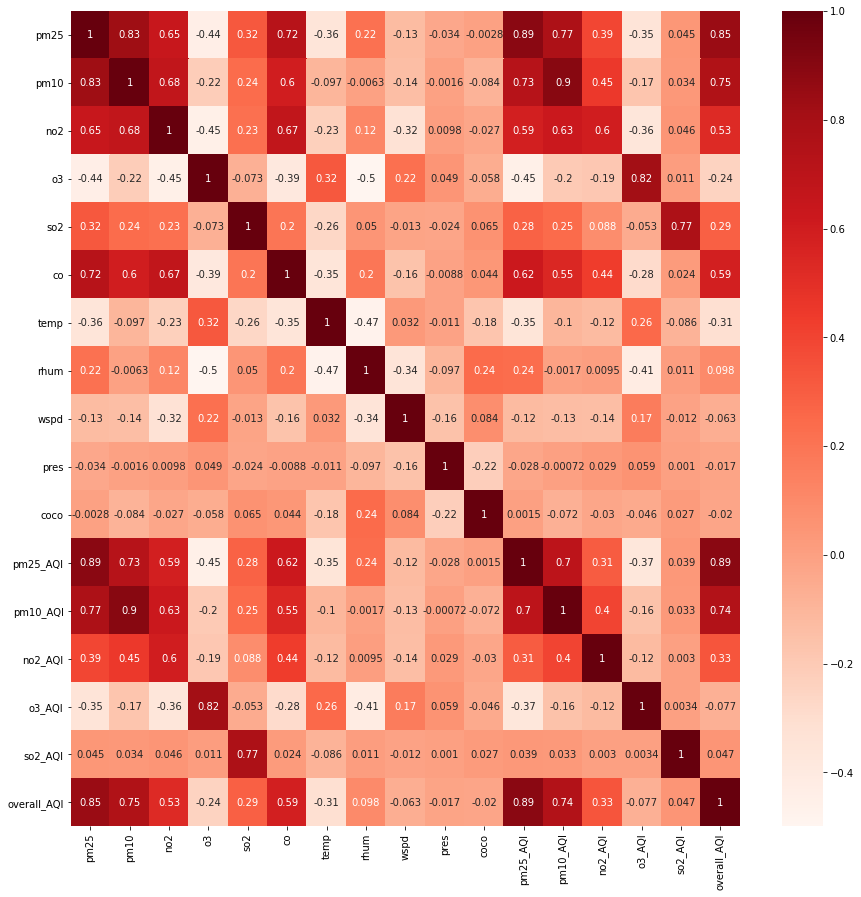

In [10]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Spearman's rho

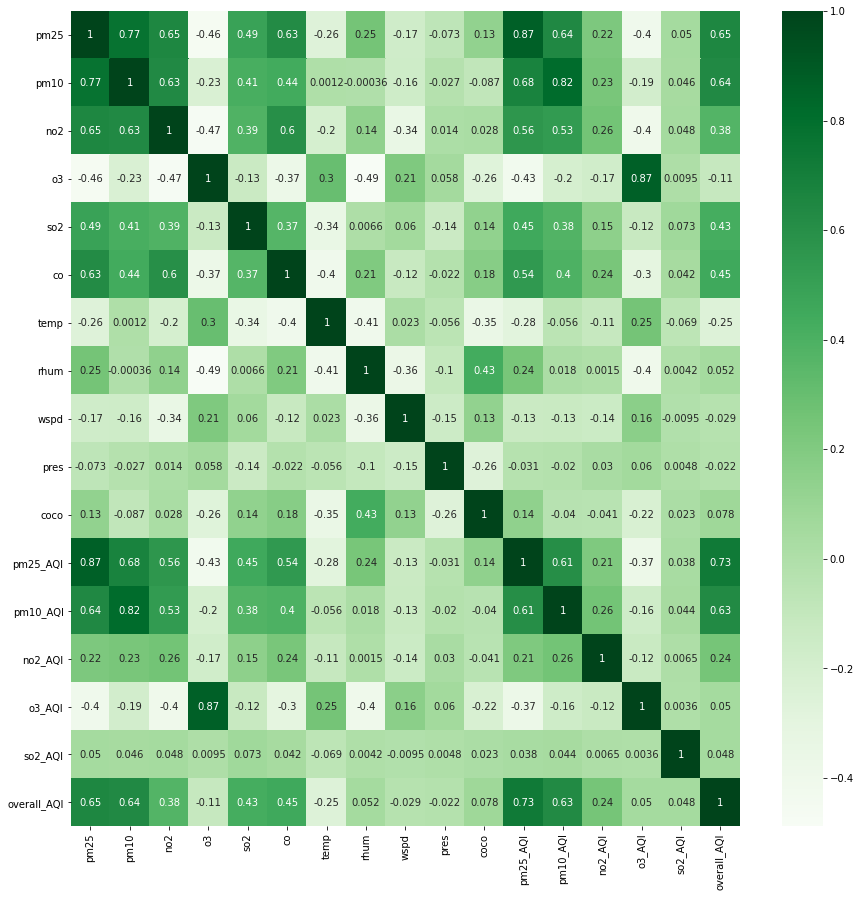

In [11]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='spearman')
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.show()

## Kendall's tau

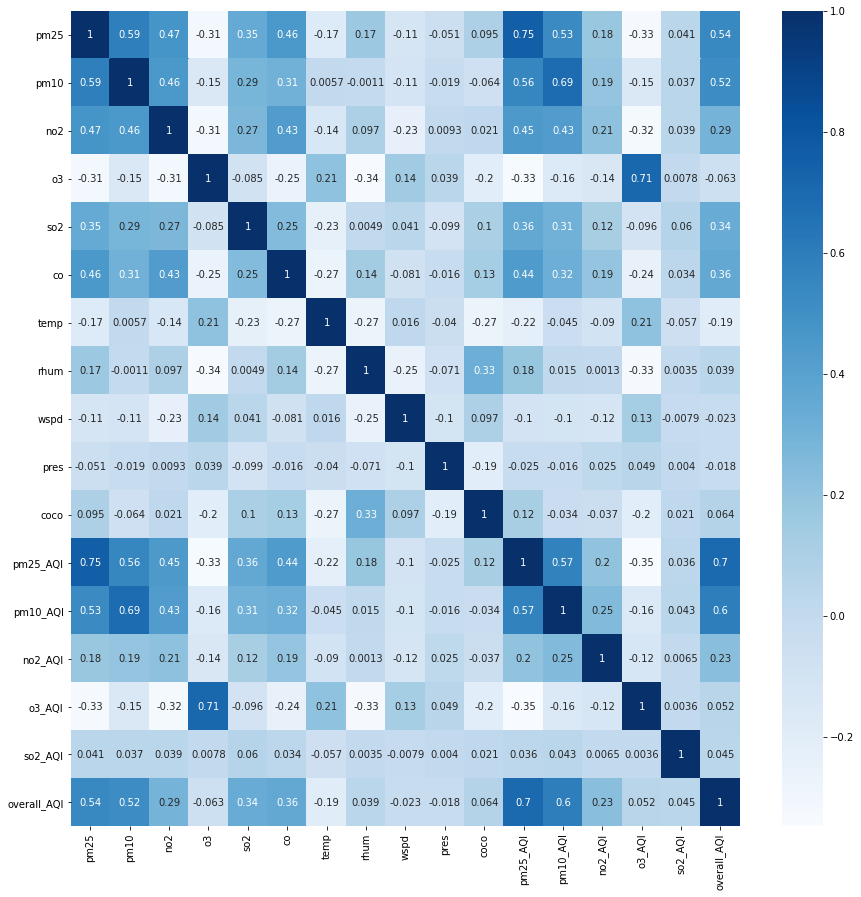

In [12]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='kendall')
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

# Data Preparation for Machine Learning Models

In [13]:
final_df.columns

Index(['pm25', 'pm10', 'no2', 'o3', 'so2', 'co', 'temp', 'rhum', 'wspd',
       'pres', 'coco', 'pm25_AQI', 'pm10_AQI', 'no2_AQI', 'o3_AQI', 'so2_AQI',
       'overall_AQI'],
      dtype='object')

In [14]:
dataset = final_df.copy()
dataset

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
2020-05-10 02:00:00,30.171400,35.165321,23.364639,36.022350,3.420006,406.509735,4.3,99.900002,0.100000,1013.000000,5.0,4.0,2.0,1.0,1.0,1.0,4.0
2020-05-10 03:00:00,24.941099,26.857201,17.198145,41.853401,2.923762,380.546509,4.3,99.900002,1.800000,1012.000000,1.0,3.0,2.0,1.0,1.0,1.0,3.0
2020-05-10 04:00:00,20.403601,24.340960,14.874060,45.850349,3.265424,341.578491,5.3,93.000000,1.800000,1012.000000,2.0,1.0,2.0,1.0,1.0,1.0,2.0
2020-05-10 05:00:00,13.340300,12.202140,9.750350,59.840752,3.237568,280.203003,11.2,58.400002,0.100000,1012.000000,2.0,2.0,1.0,1.0,2.0,1.0,2.0
2020-05-10 06:00:00,13.860800,17.599560,14.425900,55.445450,3.236954,303.834503,13.3,51.200001,12.900000,1012.000000,2.0,2.0,1.0,1.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,10.227040,17.265425,36.352360,41.576199,4.017824,349.459015,11.0,74.000000,16.700001,1023.200012,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-01 21:00:00,12.011955,17.995701,31.171181,43.122799,4.341456,341.441986,10.6,75.000000,16.700001,1023.000000,2.0,2.0,1.0,1.0,1.0,1.0,2.0
2021-10-01 22:00:00,13.455400,18.340750,29.615101,38.532951,4.863708,334.145660,10.4,77.099998,14.800000,1022.599976,2.0,2.0,1.0,1.0,1.0,1.0,2.0
2021-10-01 23:00:00,15.297300,19.497175,20.857361,44.174599,4.779466,329.587341,10.1,79.099998,14.800000,1022.099976,2.0,2.0,1.0,1.0,1.0,1.0,2.0


### Split Data

In [15]:
from sklearn.model_selection import train_test_split

features=dataset.values
targets=dataset[["pm25", "pm10", "no2", "o3", "so2"]].values

X_train, X_test, y_train, y_test  = train_test_split(features, targets, test_size=0.1, random_state=1, shuffle=False)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=1, shuffle=False)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (9913, 17)
X_test: (1224, 17)


### Data Normalizaton

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_val = scaler.transform(X_val)

X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((9913, 17), (1224, 17))

### Set up data with TimeseriesGenerator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

win_length=12
batch_size=4
num_features=features.shape[1]

train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

train_generator[0]

(array([[[0.21823789, 0.12086411, 0.23965766, 0.20864868, 0.01211078,
          0.19684425, 0.4166667 , 0.9987805 , 0.        , 0.5714283 ,
          0.16666667, 0.6       , 0.2       , 0.        , 0.        ,
          0.        , 0.6       ],
         [0.17921954, 0.09147309, 0.17163526, 0.24279816, 0.01024867,
          0.18155941, 0.4166667 , 0.9987805 , 0.03195488, 0.55101967,
          0.        , 0.40000004, 0.2       , 0.        , 0.        ,
          0.        , 0.40000004],
         [0.14536954, 0.08257157, 0.14599834, 0.26620626, 0.01153072,
          0.15861848, 0.43750003, 0.9146341 , 0.03195488, 0.55101967,
          0.04166667, 0.        , 0.2       , 0.        , 0.        ,
          0.        , 0.2       ],
         [0.09267689, 0.03962898, 0.08947886, 0.3481409 , 0.0114262 ,
          0.12248602, 0.5604167 , 0.4926829 , 0.        , 0.55101967,
          0.04166667, 0.2       , 0.        , 0.        , 0.33333334,
          0.        , 0.2       ],
         [0.09655986

# Create LSTM model

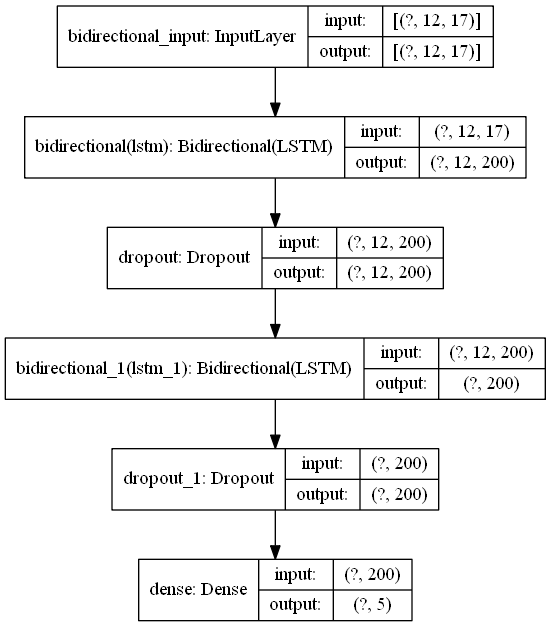

In [18]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,  return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(targets.shape[1])
])

model_LSTM.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_LSTM, show_shapes=True)

### Fit Model

In [19]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model = model_LSTM.fit(train_generator, 
                                    validation_data=val_generator,
                                    epochs=200, 
                                    shuffle=False,  
                                    callbacks=[lr_monitor, early_stopping])

Epoch 1/200
2476/2476 [==============================] - 36s 15ms/step - loss: 0.3598 - val_loss: 0.1404
Epoch 2/200
2476/2476 [==============================] - 33s 13ms/step - loss: 0.2908 - val_loss: 0.1168
Epoch 3/200
2476/2476 [==============================] - 34s 14ms/step - loss: 0.1752 - val_loss: 0.1121
Epoch 4/200
2476/2476 [==============================] - 35s 14ms/step - loss: 0.1566 - val_loss: 0.1096
Epoch 5/200
2476/2476 [==============================] - 35s 14ms/step - loss: 0.1410 - val_loss: 0.0785
Epoch 6/200
2476/2476 [==============================] - 35s 14ms/step - loss: 0.1326 - val_loss: 0.0711
Epoch 7/200
2476/2476 [==============================] - 36s 15ms/step - loss: 0.1287 - val_loss: 0.0739
Epoch 8/200
2476/2476 [==============================] - 36s 14ms/step - loss: 0.1240 - val_loss: 0.0670
Epoch 9/200
2476/2476 [==============================] - 36s 14ms/step - loss: 0.1214 - val_loss: 0.0686
Epoch 10/200
2476/2476 [==============================]

Text(0, 0.5, 'mse score')

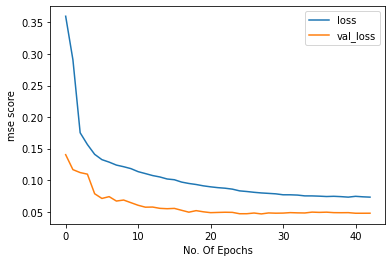

In [20]:
plt.plot(prepared_model.history["loss"],label="loss")
plt.plot(prepared_model.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [21]:
model_LSTM.evaluate(test_generator, verbose=1)

303/303 [==============================] - 2s 6ms/step - loss: 0.0561


0.05610588192939758

### Get Predictions

In [22]:
predictions=model_LSTM.predict(test_generator)

pd.DataFrame(predictions)

,0,1,2,3,4
0,7.110327,13.233315,7.140815,72.614220,2.389577
1,6.800807,13.541906,7.762167,74.060936,2.419047
2,7.300448,14.872564,9.364579,71.361580,2.447600
3,7.102859,14.223198,9.501806,69.823280,2.399502
4,7.015367,13.219654,7.860105,71.676826,2.345150
...,...,...,...,...,...
1207,10.877892,22.387375,26.247131,48.433083,3.184726
1208,11.283372,22.007414,25.160301,44.721169,2.994857
1209,11.187519,20.065395,20.086115,49.106865,2.863557
1210,12.593860,19.419966,19.291332,44.408764,2.864285


In [23]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]

df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,...,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI,pm25_pred,pm10_pred,no2_pred,o3_pred,so2_pred
2021-08-12 13:00:00,5.653327,8.732813,6.582554,72.587700,1.409954,334.587738,22.299999,53.200001,9.600000,1021.000000,...,1.0,1.0,2.0,1.0,2.0,7.110327,13.233315,7.140815,72.614220,2.389577
2021-08-12 14:00:00,5.709525,9.242850,8.127582,72.702698,1.876128,356.076752,21.299999,64.000000,11.300000,1021.000000,...,1.0,1.0,2.0,1.0,2.0,6.800807,13.541906,7.762167,74.060936,2.419047
2021-08-12 15:00:00,5.554870,8.665282,8.517628,73.013153,1.729256,366.410736,20.299999,68.000000,16.600000,1021.000000,...,1.0,1.0,2.0,1.0,2.0,7.300448,14.872564,9.364579,71.361580,2.447600
2021-08-12 16:00:00,5.772388,9.043410,7.198008,76.367447,2.034475,357.128998,19.299999,73.000000,18.299999,1021.000000,...,1.0,1.0,2.0,1.0,2.0,7.102859,14.223198,9.501806,69.823280,2.399502
2021-08-12 17:00:00,5.687860,9.020622,7.426122,77.097298,1.747246,349.056763,19.299999,77.900002,12.900000,1021.000000,...,1.0,1.0,2.0,1.0,2.0,7.015367,13.219654,7.860105,71.676826,2.345150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,10.227040,17.265425,36.352360,41.576199,4.017824,349.459015,11.000000,74.000000,16.700001,1023.200012,...,1.0,1.0,1.0,1.0,1.0,10.877892,22.387375,26.247131,48.433083,3.184726
2021-10-01 21:00:00,12.011955,17.995701,31.171181,43.122799,4.341456,341.441986,10.600000,75.000000,16.700001,1023.000000,...,1.0,1.0,1.0,1.0,2.0,11.283372,22.007414,25.160301,44.721169,2.994857
2021-10-01 22:00:00,13.455400,18.340750,29.615101,38.532951,4.863708,334.145660,10.400000,77.099998,14.800000,1022.599976,...,1.0,1.0,1.0,1.0,2.0,11.187519,20.065395,20.086115,49.106865,2.863557
2021-10-01 23:00:00,15.297300,19.497175,20.857361,44.174599,4.779466,329.587341,10.100000,79.099998,14.800000,1022.099976,...,1.0,1.0,1.0,1.0,2.0,12.593860,19.419966,19.291332,44.408764,2.864285


<AxesSubplot:>

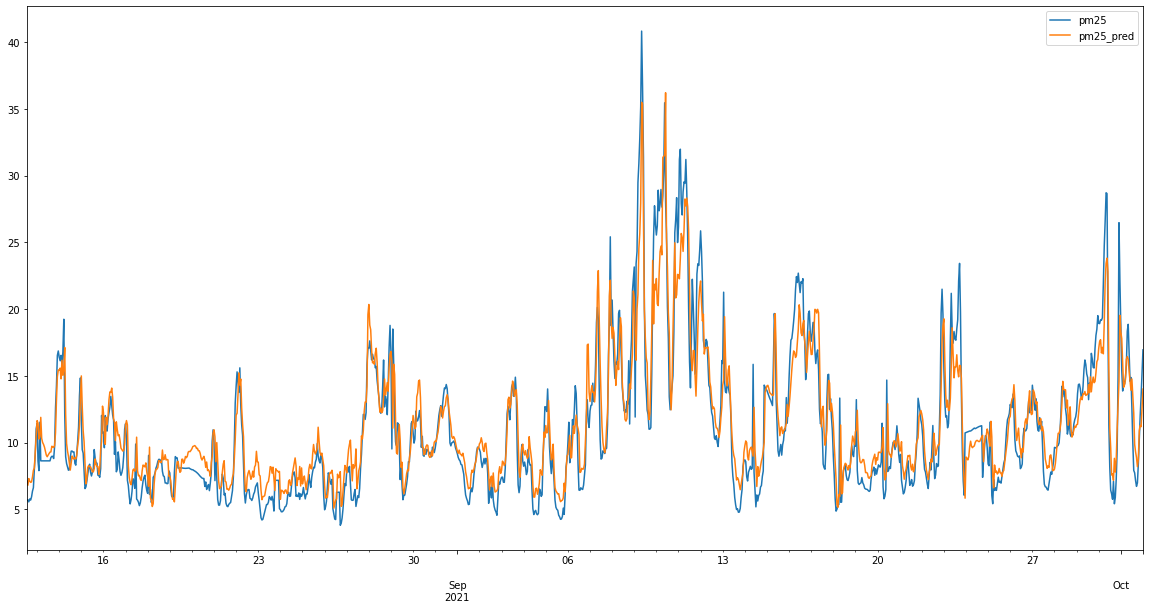

In [24]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

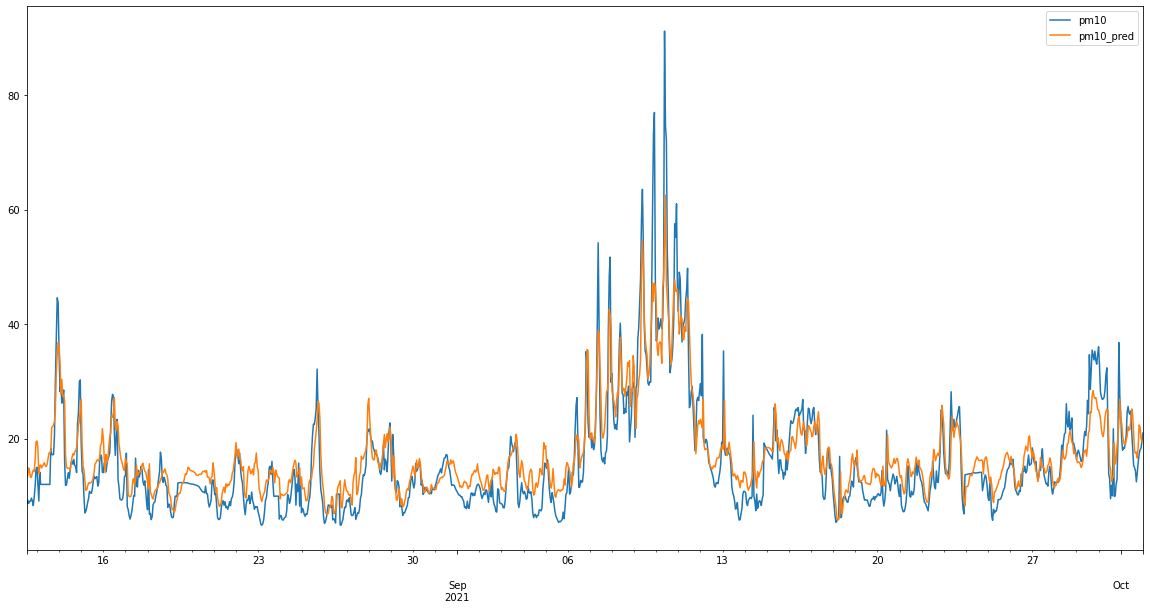

In [25]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

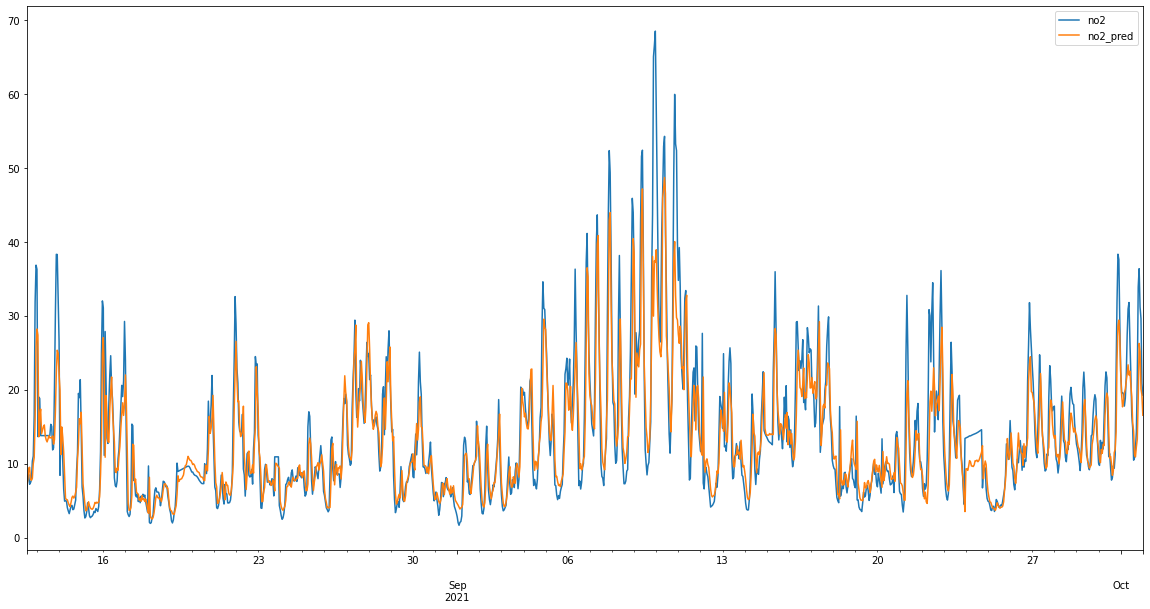

In [26]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

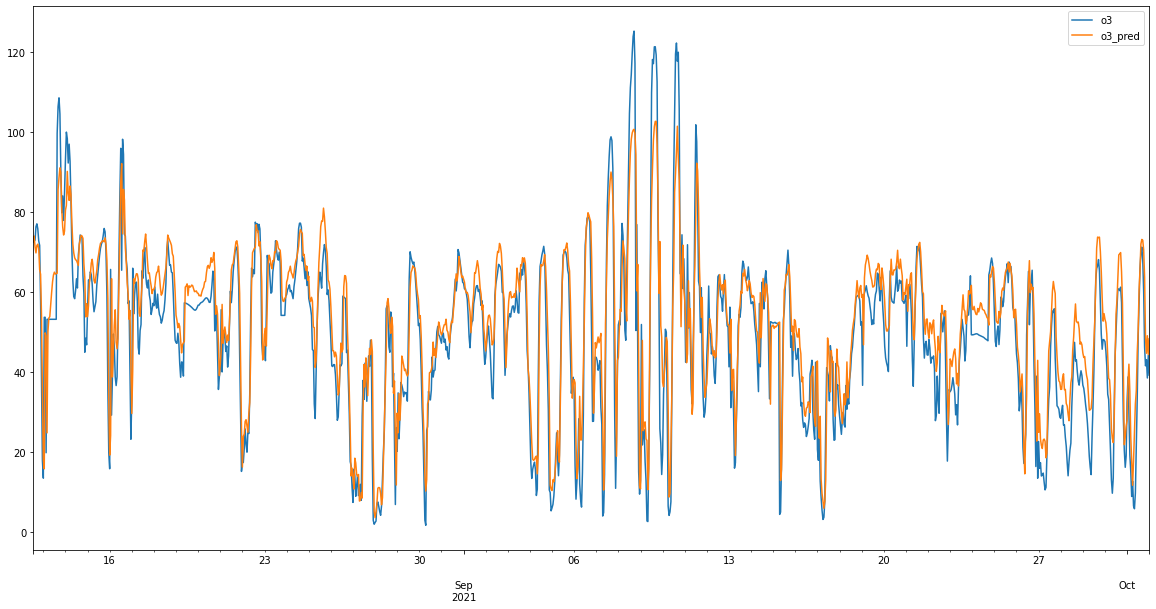

In [27]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

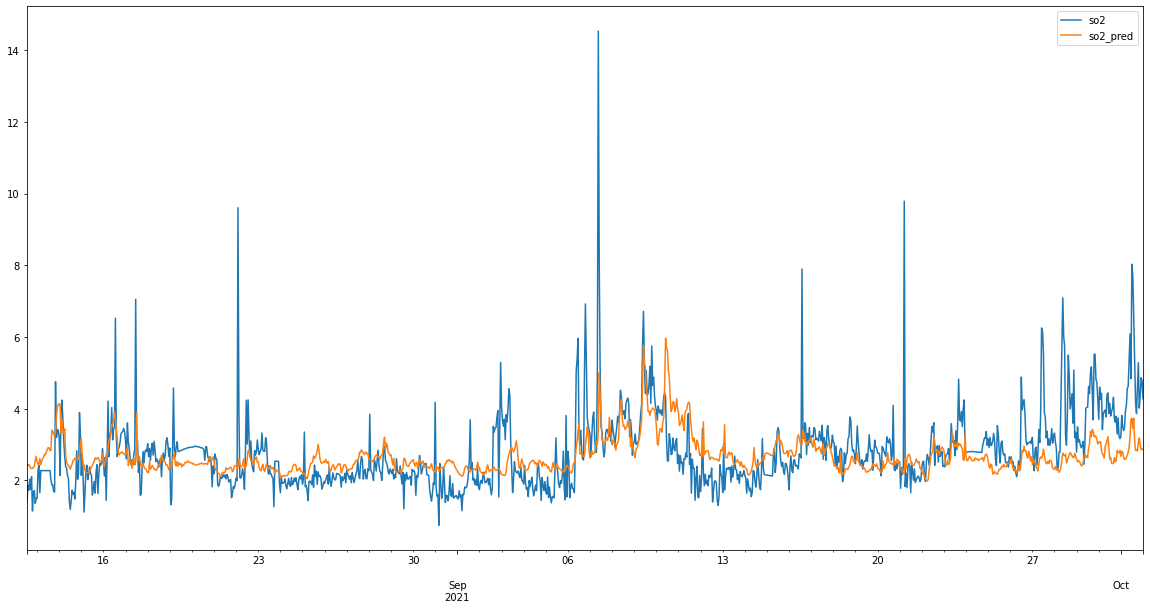

In [28]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

# Create CNN Model

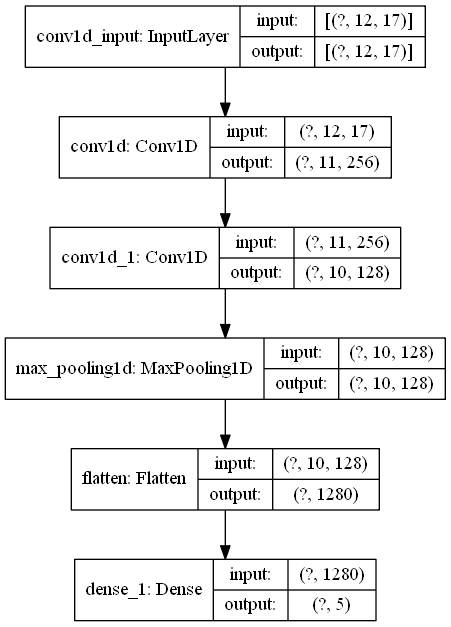

In [29]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3), input_shape=(win_length, num_features)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1])
])

model_CNN.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_CNN, show_shapes=True)

### Fit model

In [30]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model_CNN = model_CNN.fit(train_generator, 
                                       validation_data=val_generator,
                                       epochs=400, 
                                       shuffle=False,  
                                       callbacks=[lr_monitor, early_stopping])

Epoch 1/400
2476/2476 [==============================] - 12s 5ms/step - loss: 0.1979 - val_loss: 0.0975
Epoch 2/400
2476/2476 [==============================] - 11s 4ms/step - loss: 0.1261 - val_loss: 0.0787
Epoch 3/400
2476/2476 [==============================] - 11s 5ms/step - loss: 0.1145 - val_loss: 0.0729
Epoch 4/400
2476/2476 [==============================] - 12s 5ms/step - loss: 0.1053 - val_loss: 0.0685
Epoch 5/400
2476/2476 [==============================] - 11s 4ms/step - loss: 0.0992 - val_loss: 0.0631
Epoch 6/400
2476/2476 [==============================] - 11s 4ms/step - loss: 0.0961 - val_loss: 0.0607
Epoch 7/400
2476/2476 [==============================] - 11s 5ms/step - loss: 0.0915 - val_loss: 0.0589
Epoch 8/400
2476/2476 [==============================] - 13s 5ms/step - loss: 0.0908 - val_loss: 0.0572
Epoch 9/400
2476/2476 [==============================] - 14s 6ms/step - loss: 0.0856 - val_loss: 0.0567
Epoch 10/400
2476/2476 [==============================] - 14s 6m

2476/2476 [==============================] - 10s 4ms/step - loss: 0.0510 - val_loss: 0.0426
Epoch 80/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.0510 - val_loss: 0.0426
Epoch 81/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.0510 - val_loss: 0.0426
Epoch 82/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.0510 - val_loss: 0.0426


Text(0, 0.5, 'mse score')

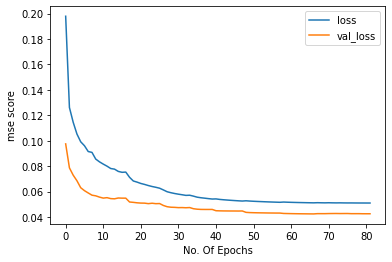

In [31]:
plt.plot(prepared_model_CNN.history["loss"],label="loss")
plt.plot(prepared_model_CNN.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [32]:
model_CNN.evaluate(test_generator, verbose=1)

303/303 [==============================] - 1s 2ms/step - loss: 0.0446


0.044642601162195206

### Get Predictions

In [33]:
predictions=model_CNN.predict(test_generator)

pd.DataFrame(predictions)

,0,1,2,3,4
0,6.795647,11.077325,7.089819,73.390099,1.643382
1,6.681349,10.851029,7.565049,71.346680,1.687092
2,7.315331,14.063782,9.395391,68.327927,1.830455
3,7.669918,15.317614,10.448705,66.744202,1.811075
4,7.768071,13.831770,8.643386,70.408691,1.816392
...,...,...,...,...,...
1207,11.706013,24.525391,32.816433,45.404736,4.601013
1208,11.953470,23.931845,29.247929,45.243172,3.612737
1209,13.629085,22.039955,23.563065,47.442669,3.999028
1210,14.356286,20.513866,23.669640,38.830868,4.536088


In [34]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]

df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,...,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI,pm25_pred,pm10_pred,no2_pred,o3_pred,so2_pred
2021-08-12 13:00:00,5.653327,8.732813,6.582554,72.587700,1.409954,334.587738,22.299999,53.200001,9.600000,1021.000000,...,1.0,1.0,2.0,1.0,2.0,6.795647,11.077325,7.089819,73.390099,1.643382
2021-08-12 14:00:00,5.709525,9.242850,8.127582,72.702698,1.876128,356.076752,21.299999,64.000000,11.300000,1021.000000,...,1.0,1.0,2.0,1.0,2.0,6.681349,10.851029,7.565049,71.346680,1.687092
2021-08-12 15:00:00,5.554870,8.665282,8.517628,73.013153,1.729256,366.410736,20.299999,68.000000,16.600000,1021.000000,...,1.0,1.0,2.0,1.0,2.0,7.315331,14.063782,9.395391,68.327927,1.830455
2021-08-12 16:00:00,5.772388,9.043410,7.198008,76.367447,2.034475,357.128998,19.299999,73.000000,18.299999,1021.000000,...,1.0,1.0,2.0,1.0,2.0,7.669918,15.317614,10.448705,66.744202,1.811075
2021-08-12 17:00:00,5.687860,9.020622,7.426122,77.097298,1.747246,349.056763,19.299999,77.900002,12.900000,1021.000000,...,1.0,1.0,2.0,1.0,2.0,7.768071,13.831770,8.643386,70.408691,1.816392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,10.227040,17.265425,36.352360,41.576199,4.017824,349.459015,11.000000,74.000000,16.700001,1023.200012,...,1.0,1.0,1.0,1.0,1.0,11.706013,24.525391,32.816433,45.404736,4.601013
2021-10-01 21:00:00,12.011955,17.995701,31.171181,43.122799,4.341456,341.441986,10.600000,75.000000,16.700001,1023.000000,...,1.0,1.0,1.0,1.0,2.0,11.953470,23.931845,29.247929,45.243172,3.612737
2021-10-01 22:00:00,13.455400,18.340750,29.615101,38.532951,4.863708,334.145660,10.400000,77.099998,14.800000,1022.599976,...,1.0,1.0,1.0,1.0,2.0,13.629085,22.039955,23.563065,47.442669,3.999028
2021-10-01 23:00:00,15.297300,19.497175,20.857361,44.174599,4.779466,329.587341,10.100000,79.099998,14.800000,1022.099976,...,1.0,1.0,1.0,1.0,2.0,14.356286,20.513866,23.669640,38.830868,4.536088


<AxesSubplot:>

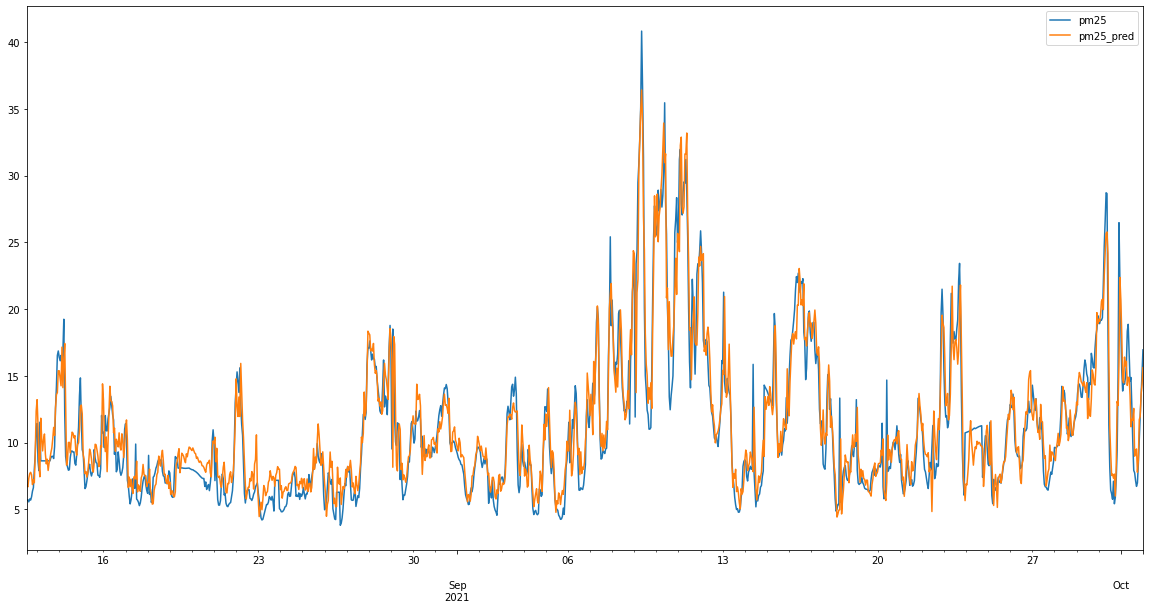

In [35]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

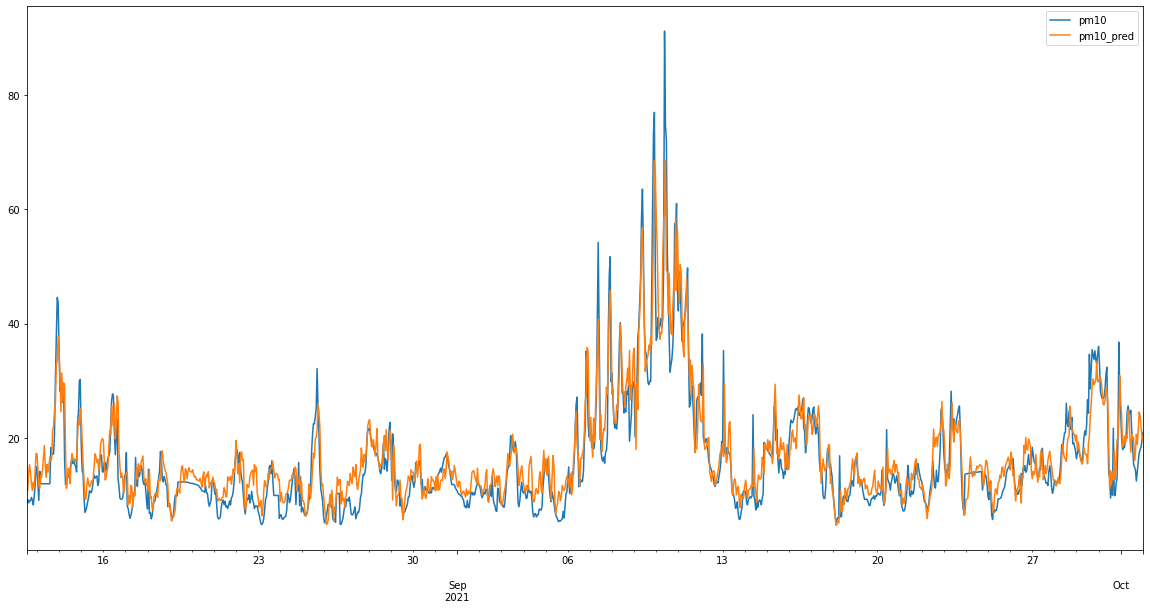

In [36]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

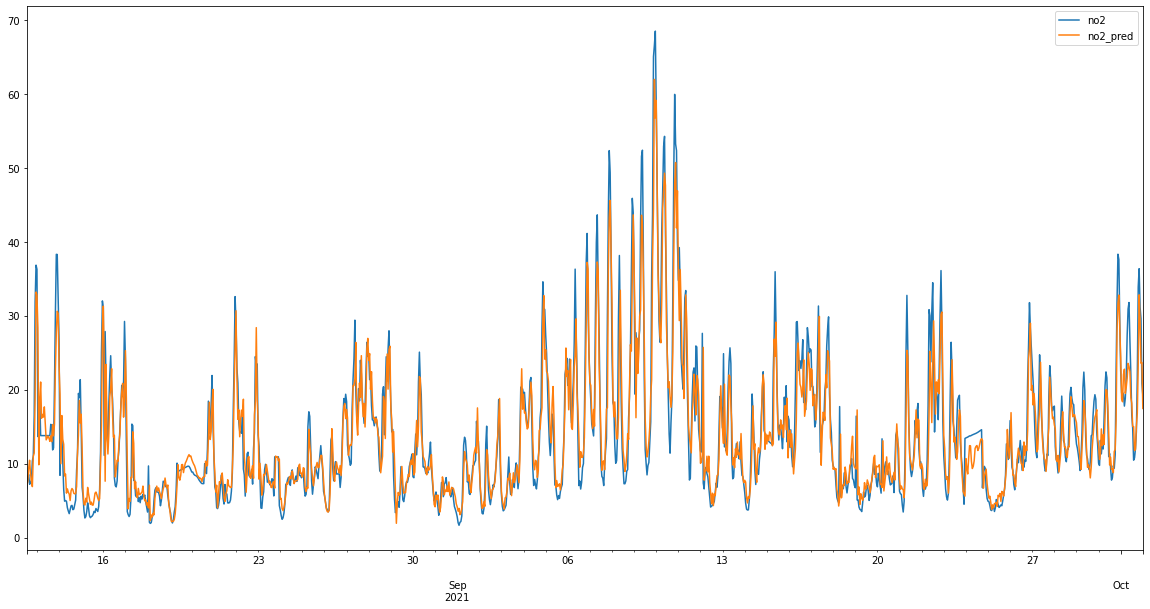

In [37]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

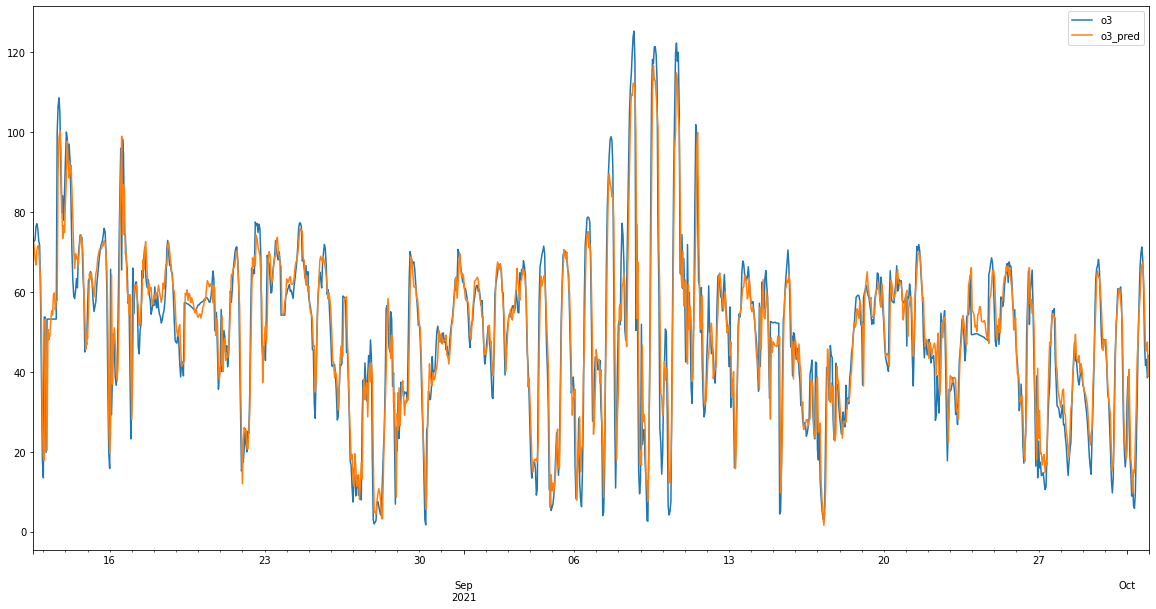

In [38]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

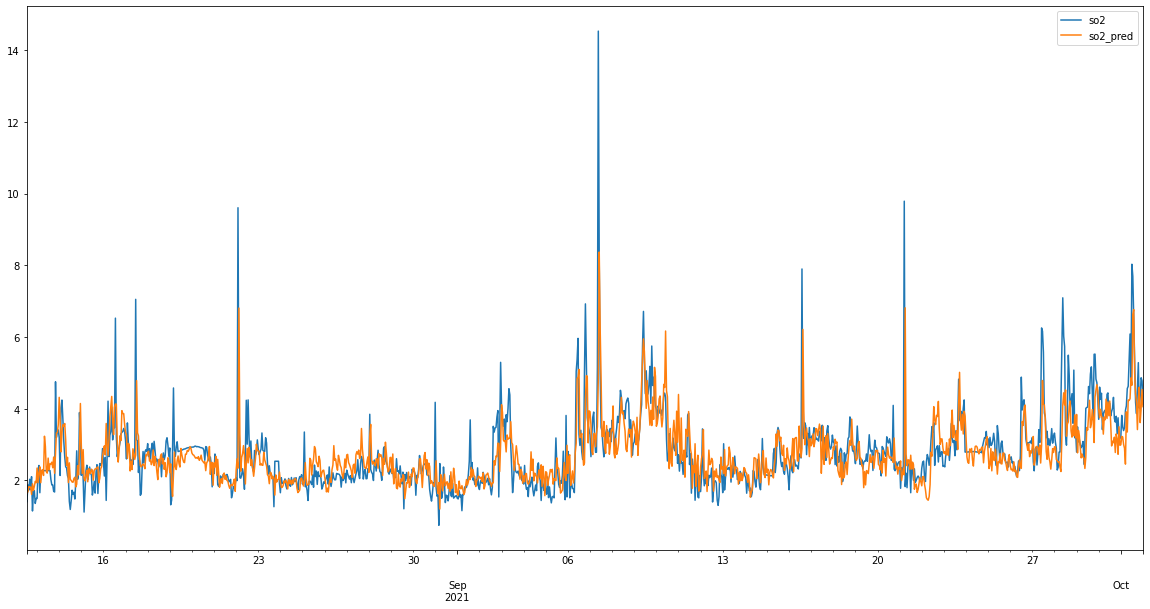

In [39]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

# LSTM-CNN Model

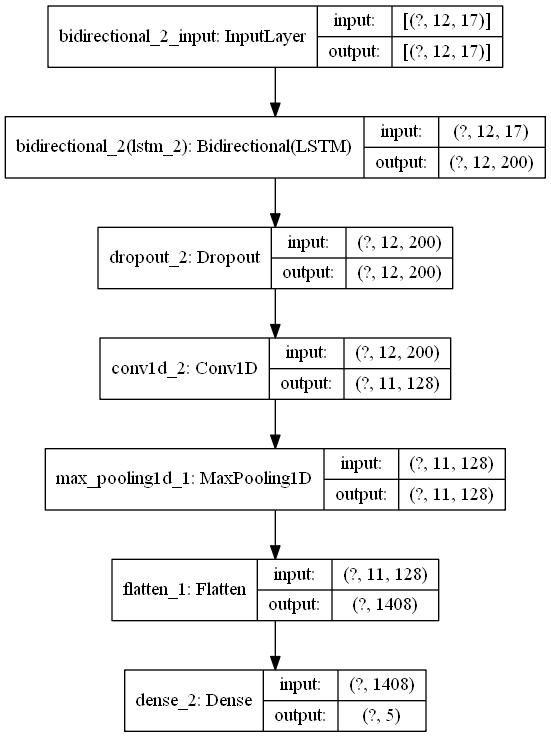

In [40]:
model_LSTMCNN = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.7)),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1])
])

model_LSTMCNN.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_LSTMCNN, show_shapes=True)

In [41]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model_CNNLSTM = model_LSTMCNN.fit(train_generator, 
                                       validation_data=val_generator,
                                       epochs=200, 
                                       shuffle=False,  
                                       callbacks=[lr_monitor, early_stopping])

Epoch 1/200
2476/2476 [==============================] - 24s 10ms/step - loss: 0.2003 - val_loss: 0.0950
Epoch 2/200
2476/2476 [==============================] - 22s 9ms/step - loss: 0.1428 - val_loss: 0.0863
Epoch 3/200
2476/2476 [==============================] - 22s 9ms/step - loss: 0.1291 - val_loss: 0.0809
Epoch 4/200
2476/2476 [==============================] - 22s 9ms/step - loss: 0.1223 - val_loss: 0.0773
Epoch 5/200
2476/2476 [==============================] - 21s 8ms/step - loss: 0.1156 - val_loss: 0.0744
Epoch 6/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.1115 - val_loss: 0.0685
Epoch 7/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.1080 - val_loss: 0.0654
Epoch 8/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.1047 - val_loss: 0.0651
Epoch 9/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.1019 - val_loss: 0.0619
Epoch 10/200
2476/2476 [==============================] - 23s 9

2476/2476 [==============================] - 24s 9ms/step - loss: 0.0676 - val_loss: 0.0402
Epoch 79/200
2476/2476 [==============================] - 25s 10ms/step - loss: 0.0676 - val_loss: 0.0402
Epoch 80/200
2476/2476 [==============================] - 24s 10ms/step - loss: 0.0676 - val_loss: 0.0402
Epoch 81/200
2476/2476 [==============================] - 24s 10ms/step - loss: 0.0674 - val_loss: 0.0402
Epoch 82/200
2476/2476 [==============================] - 25s 10ms/step - loss: 0.0675 - val_loss: 0.0402
Epoch 83/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.0675 - val_loss: 0.0402
Epoch 84/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.0673 - val_loss: 0.0402
Epoch 85/200
2476/2476 [==============================] - 24s 10ms/step - loss: 0.0676 - val_loss: 0.0402
Epoch 86/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.0676 - val_loss: 0.0402
Epoch 87/200
2476/2476 [==============================] - 23s 9

Text(0, 0.5, 'mse score')

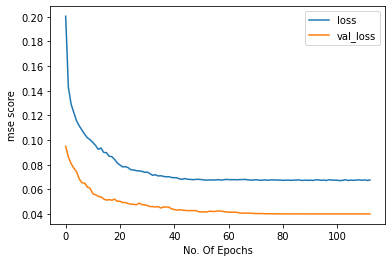

In [42]:
plt.plot(prepared_model_CNNLSTM.history["loss"],label="loss")
plt.plot(prepared_model_CNNLSTM.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [43]:
model_LSTMCNN.evaluate(test_generator, verbose=1)

303/303 [==============================] - 1s 4ms/step - loss: 0.0405


0.04050201177597046

### Get Predictions

In [44]:
predictions=model_LSTMCNN.predict(test_generator)

pd.DataFrame(predictions)

,0,1,2,3,4
0,6.277929,11.212406,6.671013,69.283028,1.934609
1,6.266784,11.683885,7.494033,69.529854,1.848157
2,7.102032,13.644552,9.694248,67.220284,1.952929
3,7.343677,13.569534,10.041230,66.700478,1.983701
4,7.187575,12.128723,7.902479,69.704712,2.005672
...,...,...,...,...,...
1207,11.944168,22.931955,30.662783,42.713833,4.556556
1208,12.094552,21.604250,28.858030,43.252808,3.696329
1209,12.167786,19.132208,24.629560,47.042091,3.761445
1210,13.311349,19.583895,24.224977,42.802879,4.163211


In [45]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]

df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,...,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI,pm25_pred,pm10_pred,no2_pred,o3_pred,so2_pred
2021-08-12 13:00:00,5.653327,8.732813,6.582554,72.587700,1.409954,334.587738,22.299999,53.200001,9.600000,1021.000000,...,1.0,1.0,2.0,1.0,2.0,6.277929,11.212406,6.671013,69.283028,1.934609
2021-08-12 14:00:00,5.709525,9.242850,8.127582,72.702698,1.876128,356.076752,21.299999,64.000000,11.300000,1021.000000,...,1.0,1.0,2.0,1.0,2.0,6.266784,11.683885,7.494033,69.529854,1.848157
2021-08-12 15:00:00,5.554870,8.665282,8.517628,73.013153,1.729256,366.410736,20.299999,68.000000,16.600000,1021.000000,...,1.0,1.0,2.0,1.0,2.0,7.102032,13.644552,9.694248,67.220284,1.952929
2021-08-12 16:00:00,5.772388,9.043410,7.198008,76.367447,2.034475,357.128998,19.299999,73.000000,18.299999,1021.000000,...,1.0,1.0,2.0,1.0,2.0,7.343677,13.569534,10.041230,66.700478,1.983701
2021-08-12 17:00:00,5.687860,9.020622,7.426122,77.097298,1.747246,349.056763,19.299999,77.900002,12.900000,1021.000000,...,1.0,1.0,2.0,1.0,2.0,7.187575,12.128723,7.902479,69.704712,2.005672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,10.227040,17.265425,36.352360,41.576199,4.017824,349.459015,11.000000,74.000000,16.700001,1023.200012,...,1.0,1.0,1.0,1.0,1.0,11.944168,22.931955,30.662783,42.713833,4.556556
2021-10-01 21:00:00,12.011955,17.995701,31.171181,43.122799,4.341456,341.441986,10.600000,75.000000,16.700001,1023.000000,...,1.0,1.0,1.0,1.0,2.0,12.094552,21.604250,28.858030,43.252808,3.696329
2021-10-01 22:00:00,13.455400,18.340750,29.615101,38.532951,4.863708,334.145660,10.400000,77.099998,14.800000,1022.599976,...,1.0,1.0,1.0,1.0,2.0,12.167786,19.132208,24.629560,47.042091,3.761445
2021-10-01 23:00:00,15.297300,19.497175,20.857361,44.174599,4.779466,329.587341,10.100000,79.099998,14.800000,1022.099976,...,1.0,1.0,1.0,1.0,2.0,13.311349,19.583895,24.224977,42.802879,4.163211


<AxesSubplot:>

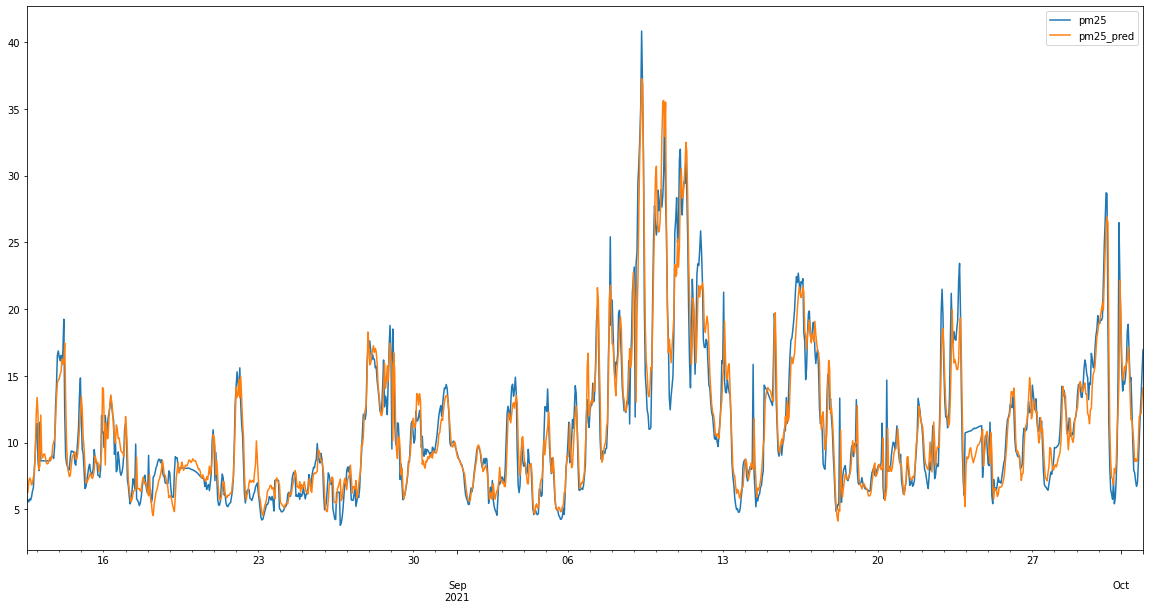

In [46]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

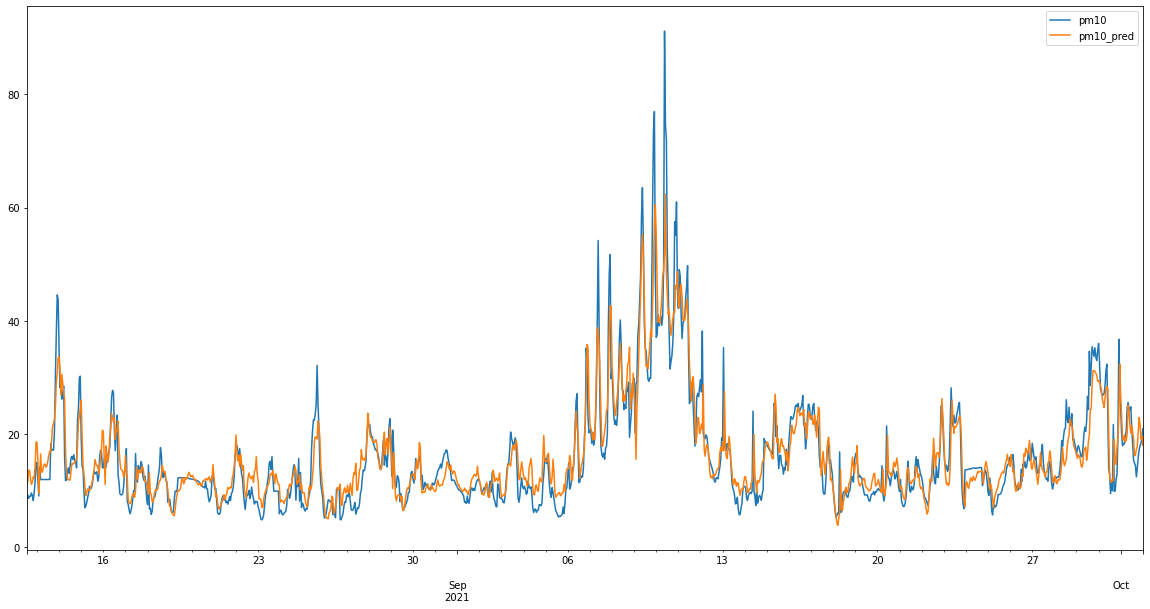

In [47]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

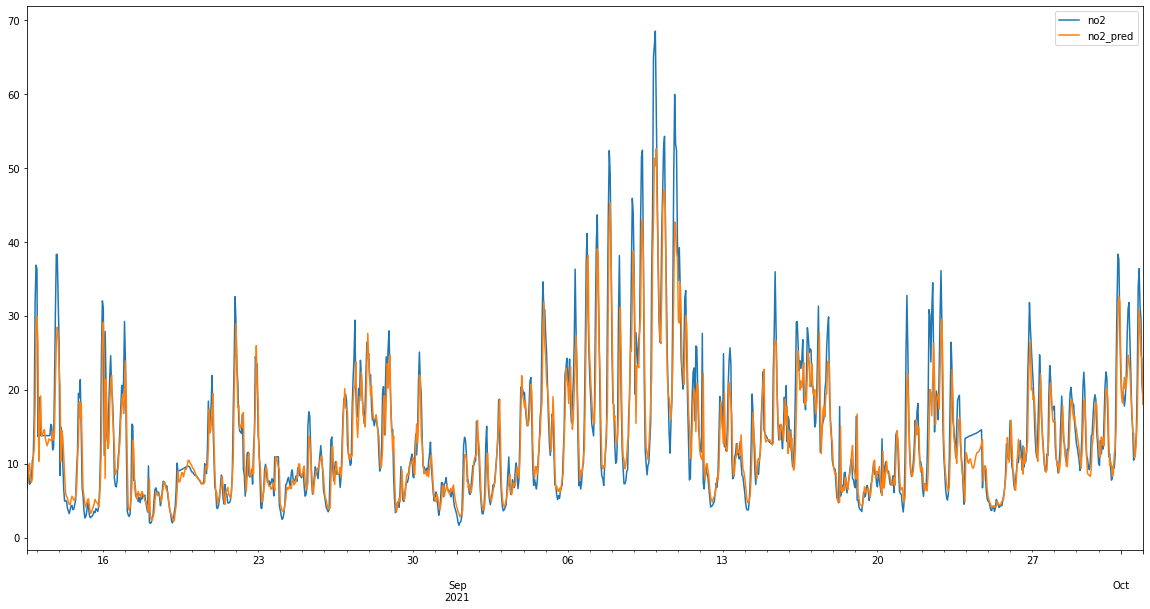

In [48]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

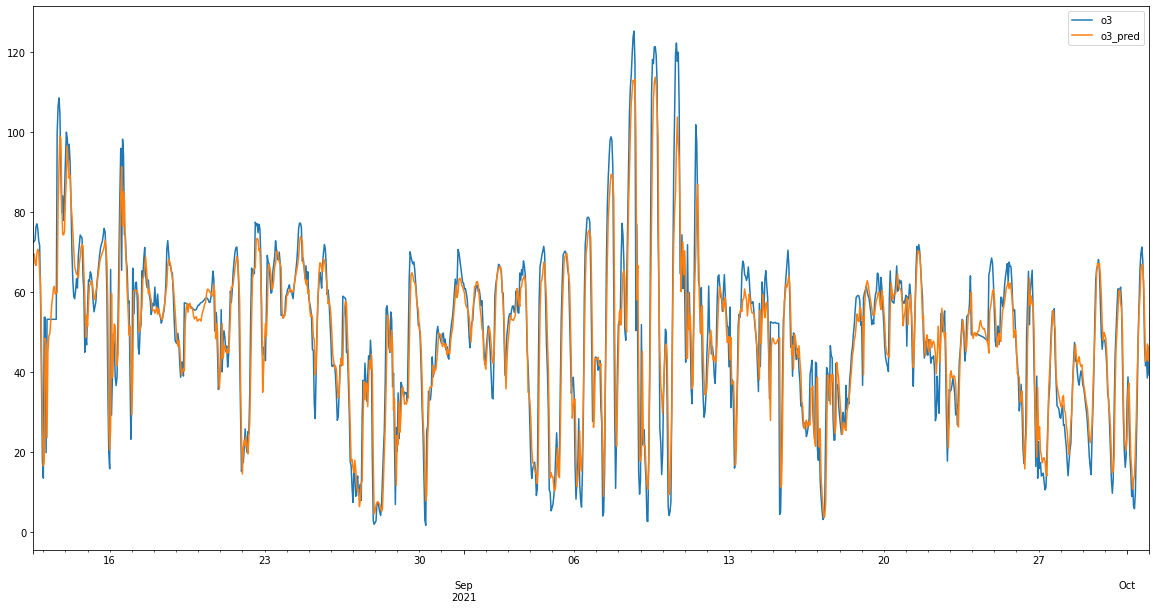

In [49]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

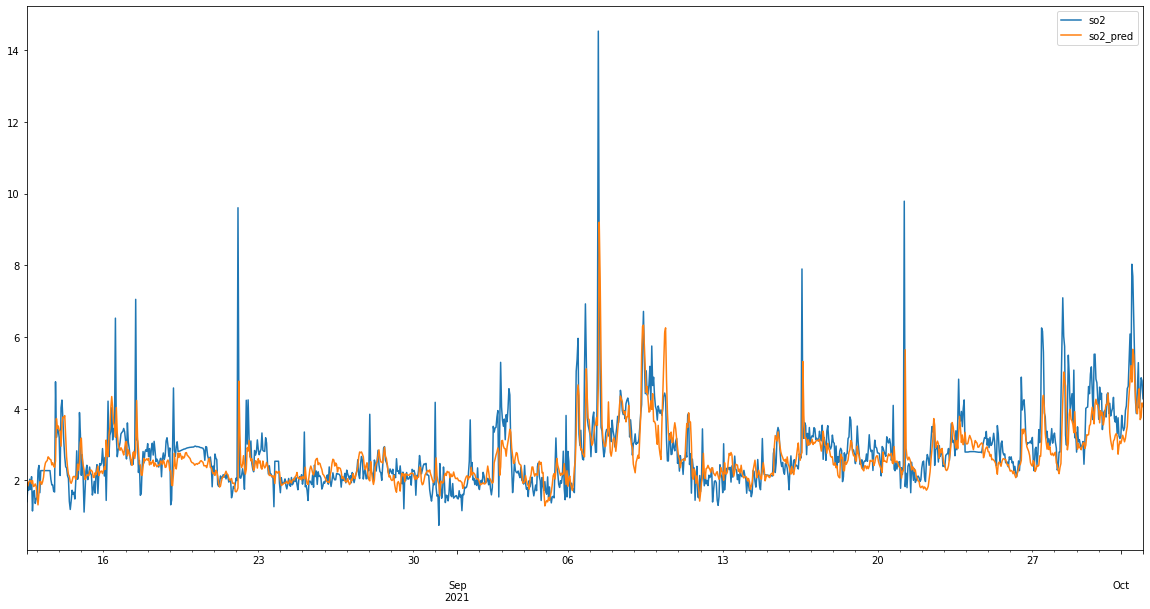

In [50]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

In [51]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mslr": mslr.numpy(),
           }

In [52]:
selected_features = ["pm25", "pm10", "no2", "o3", "so2"]

for feature in selected_features:
    print("-----{}-----".format(feature))
    print(evaluate_preds(y_true=df_final[feature].values,
                         y_pred=df_final["{}_pred".format(feature)].values)
         )

-----pm25-----
{'mae': 1.2029338, 'mse': 3.13344, 'rmse': 1.7701526, 'mape': 11.446815, 'mslr': 0.01917566}
-----pm10-----
{'mae': 2.6205854, 'mse': 15.0651655, 'rmse': 3.881387, 'mape': 18.774595, 'mslr': 0.043539822}
-----no2-----
{'mae': 2.4518015, 'mse': 14.40807, 'rmse': 3.7957964, 'mape': 18.66134, 'mslr': 0.050893933}
-----o3-----
{'mae': 5.444832, 'mse': 62.393772, 'rmse': 7.898973, 'mape': 18.576857, 'mslr': 0.062692545}
-----so2-----
{'mae': 0.4452876, 'mse': 0.5815477, 'rmse': 0.76259273, 'mape': 15.609323, 'mslr': 0.026208065}
